In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#creating a matrix of ones and zeroes for multiclass classification
def one_hot(y):
    one_hot_labels = np.zeros((y.shape[0], len(np.unique(y))))
    for i in range(y.shape[0]):
        j = y[i]
        one_hot_labels[i, j-1] = 1
    return one_hot_labels

In [3]:
#accuracy function
def accuracy_score(predictions, actual):
    return np.sum(actual == predictions)/ len(actual)

In [4]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs #number of datapoints
    self.ny = n_outputs #number of classes (10 in our case)
    self.nh = len(hidden_sizes) #number of hidden layers
    self.sizes = [self.nx] + hidden_sizes + [self.ny] #size of the neural network 
    self.accuracy= None
    self.loss = None

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1]) #initialising weights
      self.B[i+1] = np.zeros((1, self.sizes[i+1])) #initialising bias
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x)) #sigmoid activation function
  
  def softmax(self, x):
    exps = np.exp(x) #softmax activation function
    return exps / np.sum(exps)

  def forward_pass(self, x): #forward propagation
    self.A = {} #preactivation weights
    self.H = {} #postactivation values
    self.H[0] = x.reshape(1, -1) #setting the initial value
    for i in range(self.nh): #looping through all the hidden layers
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1] # a = wx + bias
      self.H[i+1] = self.sigmoid(self.A[i+1]) # h = sigmoid(a)

      #setting preactivated weights for all the nodes in each layer
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]

      #setting postactivated values for all the nodes in each layer
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = [] 
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)

    #reshaping the y values to the required dimensions of one hot encoder and returning
    return np.array(Y_pred).squeeze() 
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    #cross entropy as the loss function
    yl=np.multiply(pred,label) #elementwise multiplication of actual class x predicted value
    yl=yl[yl!=0] #not taking value of 0, as its log cannot be taken
    yl=-np.log(yl) #taking log
    yl=np.mean(yl) #taking the average
    return yl
 
  def grad(self, x, y): #backward propagation
    self.forward_pass(x) #making use of the results of forward propagation
    self.dW = {} #derivatives of weights
    self.dB = {} #derivatives of biases
    self.dH = {} #derivatives of postactivation 
    self.dA = {} #derivatives of preactivation
    L = self.nh + 1 #setting value to loop
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k]) #taking derivative of weight for kth layer
      self.dB[k] = self.dA[k] #taking derivative of bias for kth layer
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T) #taking derivative of postactivation for kth layer. These values depend on the preactivation values
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) #taking derivative of preactivation for kth layer. These values depend on the activation function (sigmoid)
    
  def fit(self, X, Y, epochs=100, initialize='True',
               learning_rate=0.01, display_loss=False, display_accuracy= False):
    acc =[]  # list to store the accuracy for each epoch
    if display_loss:
      loss = {} #loss to store the loss for each epoch
    if initialize:

      #initialising the weights and biases for all the nodes in all the layers
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      #loss per epoch
      l =[]
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        #initialising a matrix of zeros for weight and bias derivatives
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))


      for x, y in zip(X, Y):
        self.grad(x, y) #starting backwardpropagation
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1] #storing derivative of weight to dictionary
          dB[i+1] += self.dB[i+1] #storing derivative of bias to dictionary
        
                  
      m = X.shape[1] # number of features
      for i in range(self.nh+1):
        #updating the weights and biases for each node in all the layers
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)

        Y_pred = self.predict(X) #making predictions
        l.append(self.cross_entropy(Y, Y_pred)) #calculating the loss for the prediction
      acc.append((1-(sum(l)/len(X)))*100) #calculating the accuracy for the epoch
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    self.loss = loss      
    self.accuracy = acc

    #plotting the loss and accuracy curves
    if display_loss: 
      plt.subplot(2, 1, 1)   
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.title(f'Loss for learning rate: {learning_rate}, and layers: {self.nh}')
      plt.show()

    if display_accuracy:
      plt.subplot(2, 1, 2)
      plt.plot(acc)
      plt.ylabel('Accuracy')
      plt.xlabel("Epochs:")
      plt.title(f'Accuracy for learning rate: {learning_rate}, and layers: {self.nh}')
      plt.show()


In [5]:
data = pd.read_csv('dataset_NN.csv')

In [6]:
data.head()

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1


In [7]:
def process(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X = (X-X.mean(axis= 0)) / X.std(axis= 0)

    return X, y

In [8]:
X, y = process(data)

In [9]:
def split_train_test(X, y, split, seed):

    #creating the training and testing dataset
    rows = int(X.shape[0] * split)
    indices = np.arange(X.shape[0])
    np.random.seed(seed)
    np.random.shuffle(indices)
    train = indices[:rows]
    test = indices[rows:]

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.7, 23)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [11]:
y_OH_train = one_hot(y_train)
y_OH_test = one_hot(y_test)

<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


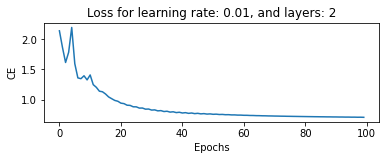

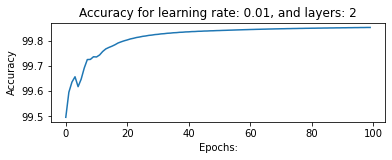

In [12]:
# For 2 hidden layers- each layer has 25 nodes [25, 25]
# lr = 0.01
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25, 25])
nn.fit(X_train, y_OH_train, learning_rate= 0.01, display_loss= True, display_accuracy= True)

In [13]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.85187053821649
Final training loss: 0.7041364004624359


In [14]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1 
#we add one, because python indexing starts from 0, but our classes start from 1

In [15]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.6933333333333334


<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


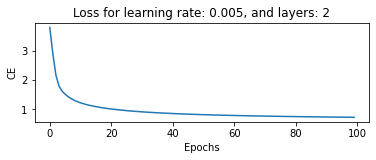

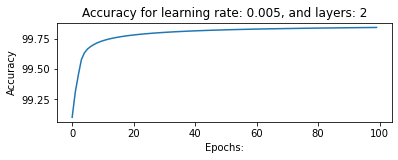

In [16]:
# For 2 hidden layers- each layer has 25 nodes [25, 25]
# lr = 0.005
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25, 25])
nn.fit(X_train, y_OH_train, learning_rate= 0.005, display_loss= True, display_accuracy= True)

In [17]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.84343263832352
Final training loss: 0.7301823450564595


In [18]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1

In [19]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.7066666666666667


<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


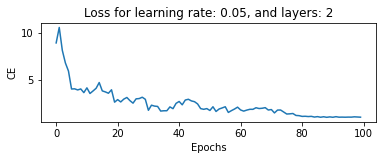

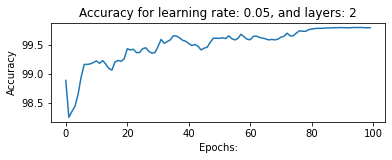

In [20]:
# For 2 hidden layers- each layer has 25 nodes [25, 25]
# lr = 0.05
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25, 25])
nn.fit(X_train, y_OH_train, learning_rate= 0.05, display_loss= True, display_accuracy= True)

In [21]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.7906428043434
Final training loss: 0.9815624934743851


In [22]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1

In [23]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.575


<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


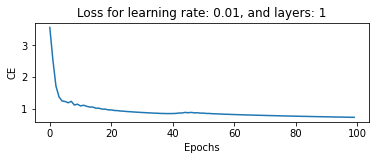

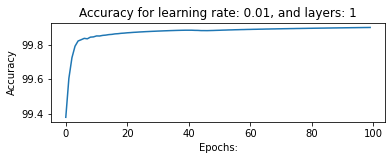

In [24]:
# For 1 hidden layer with 25 nodes
# lr = 0.01
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25])
nn.fit(X_train, y_OH_train, learning_rate= 0.01, display_loss= True, display_accuracy= True)

In [25]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.89862432793014
Final training loss: 0.7227542484333063


In [26]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1

In [27]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.7233333333333334


<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


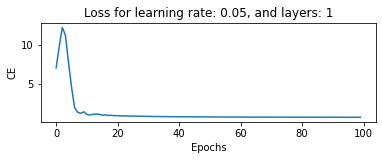

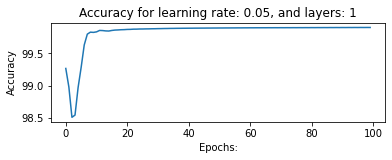

In [28]:
# For 1 hidden layer with 25 nodes
# lr = 0.05
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25])
nn.fit(X_train, y_OH_train, learning_rate= 0.05, display_loss= True, display_accuracy= True)

In [29]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.90087247631527
Final training loss: 0.7126884390740275


In [30]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1

In [31]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.69


<ipython-input-4-e78e4adf89b7>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


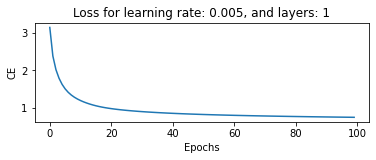

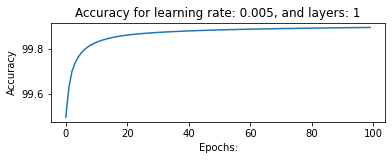

In [32]:
# For 1 hidden layer with 25 nodes
# lr = 0.005
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [25])
nn.fit(X_train, y_OH_train, display_loss= True, display_accuracy= True, learning_rate= 0.005)

In [33]:
print(f'Final training accuracy: {nn.accuracy[-1]}')
print(f'Final training loss: {nn.loss[99]}')

Final training accuracy: 99.89391776823238
Final training loss: 0.7423123985561815


In [34]:
predictions = nn.predict(X_test)
predictions = np.argmax(predictions, 1)+1 

In [35]:
accuracy_test = accuracy_score(predictions, y_test)
print(accuracy_test)

0.68
